# Flow Across Bump - Energetics

In [1]:
# %load /Users/gunnar/Projects/python/standard_imports.py
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import gsw
import cmocean

# import own modules (install from https://github.com/gunnarvoet/pythonlib))
import gvpy.gvimport as gvi
import gvpy.figure as gvf
import gvpy.misc as gv
import gvpy.ocean as gvo
import spfunctions.spfunctions as spf

# Automatically reload modules. Use this for modules that will be modified while
# editing this notebook.
# Option 1 means only reload modules given in aimport.
# Option 2 means reload all except for those in aimport
# Running %aimport by itself will show what it is doing.
%reload_ext autoreload
%autoreload 1
%aimport spfunctions
%aimport gvpy
%aimport gvpy.misc
%aimport gvpy.ocean
%aimport gvpy.figure
%aimport gvpy.gvimport

import warnings
warnings.filterwarnings('ignore')

## Read model data

In [2]:
DataDir = '/Volumes/svalbard/mitgcm/bump/B6/run/allmnc/'
# DataDir = '/Users/gunnar/Projects/model/bump_data/B6/allmnc/'

# read grid parameters, diagnostics output and state variables
b6 = xr.open_dataset(DataDir+'diag1.glob.nc')
b6s = xr.open_dataset(DataDir+'state.glob.nc')
grid = xr.open_dataset(DataDir+'grid.glob.nc')
# load additional diagnostics
b62 = xr.open_dataset(DataDir+'diag2.glob.nc')
# |PHIBOT  |  1 |       |SM      M1|m^2/s^2         |Bottom Pressure Pot.(p/rho) Anomaly
# |ETAN    |  1 |       |SM      M1|m               |Surface Height Anomaly

In [3]:
fileName = '/Users/gunnar/Projects/model/flow-across-bump/B6/input/Tref'
tref = np.fromfile(fileName)

## Easier plotting of fields

In [11]:
def CenterPlot(dy=50,ax=0):
    if ax==0:
        ax = plt.gca()
    ax.set(xlim=my.values+(-dy,dy))

In [12]:
def PlotField(F):
    fig,ax = plt.subplots()
    ax.pcolormesh(grid.Y/1e3,grid.Z,np.ma.masked_where(np.squeeze(grid.HFacC)<1,np.squeeze(F)))
    CenterPlot()

## Derive basic variables

In [13]:
# center of domain in km
my = grid.Y.mean()/1000
# print(my)

In [25]:
# Density
rho0 = 9.998000000000000e02 # from STDOUT, e.g.: grep -A 1 'rho' STDOUT.0000
gravity = 9.81
talpha = 2.0e-4
# convert reference temperature profile to matrix
trefm = np.tile(tref,(2000,1))
trefm = np.transpose(trefm)
# calculate densities
temp = np.squeeze(b6.THETA.values)
rho = rho0*(1-talpha*(temp))
rhopert = -rho0*talpha*(temp-trefm)
rhoref = -rho0*talpha*trefm

In [15]:
# Pressure
phi_hyd = b6.PHIHYD
phi_nh = b6s.phi_nh

# interpolate phi_nh to the time vector of phi_hyd
tmp = np.squeeze(phi_nh)
phi_nh2 = (tmp[1:,:,:].values + tmp[:-1,:,:].values) / 2
phi_hyd2 = np.squeeze(phi_hyd.values)

# R coordinate of cell center units: m
RC = np.tile(grid.RC,(2000,1))

# pressure perturbation
PP = phi_hyd2*rho0 + phi_nh2*rho0

In [16]:
# Bathy Mask
BathyMask = np.squeeze(np.copy(grid.HFacC.values))
BathyMask[BathyMask<1] = 0
BathyMaskNaN = BathyMask.copy()
BathyMaskNaN[BathyMask<1] = np.nan

BathyMaskF = np.squeeze(np.copy(grid.HFacS.values))
BathyMaskF[BathyMaskF<1] = 0
BathyMaskFNaN = BathyMaskF.copy()
BathyMaskFNaN[BathyMaskF<1] = np.nan

In [17]:
# Baroclinic pressure
PPbt = np.tile(np.transpose(np.mean(PP*BathyMask,axis=1)),(100,1,1))
PPbt = np.rollaxis(PPbt,2,0)
PPbc = (PP-PPbt)*BathyMask

In [18]:
phibot = b62.PHIBOT*rho0

## Barotropic/Baroclinic Velocities
The horizontal barotropic velocity $V$ is defined as
$$V = \frac{1}{H} \int_{-d}{\eta}\, v\, dz = \frac{1}{H} \overline{u}$$

In [19]:
# barotropic horizontal velocity
# Include the bottom cell as a fraction
# Should also include the eta part at the surface (although omitting this
# for now, the error should really be minor as H>>eta)

# bring drF (cell height at faces) to matrix form
drF = np.tile(grid.drF.values.T,(2001,1))
drF = drF.T
# calculate depth at the grid faces from drF and HFacS
DepthS = np.sum(drF*np.squeeze(grid.HFacS.values),axis=0)
V = np.sum(np.squeeze(b6.VVEL.values)*drF*np.squeeze(grid.HFacS.values),axis=1) / DepthS

In [20]:
# Baroclinic horizontal velocity
V2 = np.tile(V,(100,1,1))
V3 = np.rollaxis(V2,0,2)
v = np.squeeze(b6.VVEL.values)-V3
v = v*BathyMaskFNaN

In [21]:
# Barotropic vertical velocity
drFC = np.tile(grid.drF.values.T,(2000,1))
drFC = drFC.T
# bring dyF to matrix form
dyFC = np.tile(grid.dyF.values.T,(100,1))
WF = np.squeeze(b6.WVEL)
# interpolate to cell centers. there are no velocities defined at the bottom of the lowest cells. We'll simply repeat
# the velocities from the cells above to end up with the right dimensions here.
# np.dbstack() only works along the 3rd (last?) dimension, so we have to roll axes...
WFr = np.rollaxis(WF.values,1,3)
WF2 = np.dstack((WFr,WF[:,-1,:]))
WF2 = np.rollaxis(WF2,2,1)
WC = (WF2[:,1:,:]+WF2[:,:-1,:]) / 2
# calculate depth at the grid faces from drFC and HFacC
DepthC = np.sum(drFC*np.squeeze(grid.HFacC.values),axis=0)
# calculate barotropic vertical velocity
W = np.sum(np.squeeze(WC)*drFC*np.squeeze(grid.HFacC.values),axis=1) / DepthC

In [22]:
# Baroclinic vertical velocity
# we need to bring W to the same shape as the velocity matrix WC
W2 = np.tile(W,(100,1,1))
W3 = np.rollaxis(W2,0,2)

w = np.squeeze(WC)-W3
w = w*BathyMaskNaN

## Energy

### Kinetic Energy
The kinetic energy per unit volume, in units of J/m$^3$, is defined as

$$ E_k = \frac{1}{2} \rho_0 \mathbf{u} \cdot \mathbf{u}$$
$$ E_k = E_{hk0} + E'_k + E'_{hk0}$$

where (for our 2D case with east-west velocities being close to zero):

$$ E_{hk0} = \frac{1}{2} \rho_0 \mathbf{U_H} \cdot \mathbf{U_H} = \frac{1}{2} \rho_0 V^2$$
$$ E'_k = \frac{1}{2} \rho_0 (\mathbf{u'_H} \cdot \mathbf{u'_H} +w^2) = \frac{1}{2} \rho_0 (v^2 + w^2)$$
$$ E'_{hk0} = \frac{1}{2} \rho_0 \mathbf{U} \cdot \mathbf{u'} = \frac{1}{2} \rho_0 V v'$$

with the barotropic horizontal kinetic energy $E_{hk0}$, baroclinic kinetic energy $E'_k$ and the cross term $E'_{hk0}$. The depth-integrated kinetic energy is

$$\overline{E_k} = \overline{E_{hk0}} + \overline{E'_k} + \overline{E'_{hk0}}$$
$$\overline{E_k} = H E_{hk0} + \overline{E'_k} +0.$$

In [70]:
# interpolate horizontal velocities from faces to center
VF = np.squeeze(b6.VVEL.values)
VallC = (VF[:,:,1:]+VF[:,:,:-1]) / 2
# interpolate barotropic velocity
VC = (V[:,1:]+V[:,:-1]) / 2
# ... and bring to size of baroclinic velocities
VCm = np.tile(VC,(100,1,1))
VCm = np.rollaxis(VCm,0,2)
# and baroclinic velocity
vc = (v[:,:,1:]+v[:,:,:-1]) / 2

In [61]:
# full kinetic Energy
Ek = 1/2*rho0*(VallC**2 + WC**2)
Ek = np.squeeze(Ek)*BathyMaskNaN

In [74]:
# barotropic horizontal kinetic energy
Ehk0 = 0.5*rho0*VC**2
# bring to matrix form for plotting
Ehk0m = np.tile(Ehk0,(100,1,1))
Ehk0m = np.rollaxis(Ehk0m,0,2)

In [46]:
# baroclinic kinetic Energy
Ekp = 0.5*rho0*(vc**2 + w**2)

In [72]:
# cross term
Ehk0p = 0.5*rho0*VCm*vc

Plot $E_k$, $E_{hk0}$, $E'_k$ and $E'_{hk0}$ for last time step

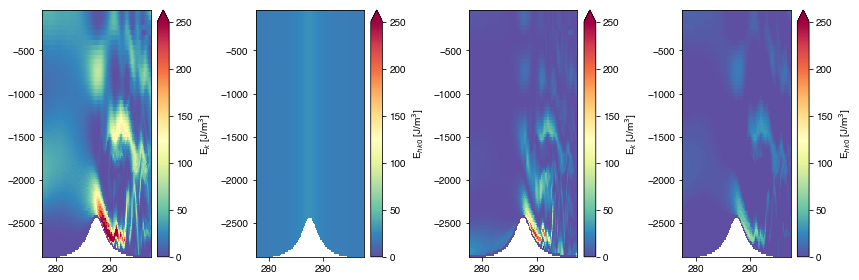

In [103]:
fig,ax = plt.subplots(ncols=4,figsize=(12,4))

TimeStep = -1
MaxC = 250

# all
EkMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ek[TimeStep,:,:]))
h = ax[0].pcolormesh(grid.Y/1e3,grid.Z,EkMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[0])
plt.colorbar(h,extend='max',label='E$_k$ [J/m$^3$]',ax=ax[0]);

# barotropic
Ehk0Masked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0m[TimeStep,:,:]))
h = ax[1].pcolormesh(grid.Y/1e3,grid.Z,Ehk0Masked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[1])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[1]);

# baroclinic
EkpMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ekp[TimeStep,:,:]))
h = ax[2].pcolormesh(grid.Y/1e3,grid.Z,EkpMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
# ax[0].contour(grid.Y/1e3,grid.Z,Ekpma,levels=[100],colors='k')
# plt.contour(grid.Y/1e3,grid.Z,Ekinma,levels=[2, 300],colors='k')
CenterPlot(10,ax[2])
plt.colorbar(h,extend='max',label='E''$_k$ [J/m$^3$]',ax=ax[2]);

# cross-terms
Ehk0pMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0p[TimeStep,:,:]))
h = ax[3].pcolormesh(grid.Y/1e3,grid.Z,Ehk0pMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[3])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[3]);


plt.tight_layout()

Depth-integrated kinetic energy

In [ ]:
drFm = np.tile(grid.drF.values,(2000,1))
drFm = drFm.T
drFm.shape

In [ ]:
Ekind = np.nansum(Ekin*drFm,axis=1)
Ekinbcd = np.nansum(Ekinbc*drFm,axis=1)

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
for i in np.linspace(10,150,5,dtype='int'):
    ax.plot(grid.Y/1e3,Ekinbcd[i,:])
ax.set(ylabel=r'$\int EK \, dz$ [J/m$^2$]',title='baroclinic EK')
CenterPlot()

### Potential Energy
Perturbation Potential Energy [J/m$^2$]
$$ \overline{E_{p0}} = \int_0^\eta \rho_0\, g\, z\, dz = 1/2\, \rho_0\, g\, \eta^2$$

In [ ]:
Ep0 = np.squeeze(1/2*rho0*gravity*eta.values**2)
Ep0.shape

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.pcolormesh(grid.Y/1e3,b6['T']/3600,Ep0,vmin=0,vmax=50,cmap='YlGnBu_r')
plt.colorbar(h,extend='max',label='E$_{P0}$ [J/m$^2$]');

Available Potential Energy per unit volume [J/m$^3$]
$$  E_p' = \int_{z-\zeta}^z g [\rho(z)-\rho_r(z')]dz' $$

The APE can be approximated with the Linear Available Potential Energy Density, $APE$ and $APE_{lin}$ are the same when the stratification of the fluid is constant.
$$ APE_{lin} = \frac{g^2 \rho'^2}{2 \rho_0 N^2} $$

In this case, we can use the linearized APE but would have to create a look-up table for the vertical distance of a given density to the reference density profile if stratification was non-linear.

In [ ]:
APE = gravity**2*(rhopert*BathyMaskNaN)**2/(2*rho0*1e-6)
# bring APE to same times as kinetic energy
APE = (APE[1:,:,:]+APE[-1,:,:]) / 2

Calculate APE following Lamb as in the lee wave paper

In [ ]:
def CalculateAPE(ty, ctd):
    ffsg = np.array(ctd['sg4filt'])
    ffz = np.array(ctd['z'])
    Ea = np.array([])
    for sg4 in ty.gsw_sigma4.values.T:
    # sg4 = ty.gsw_sigma4.values[:,11]
        zz = ty.z.values
        H = np.array([])
        drho = np.array([])
        for r, z in zip(sg4, zz):
            if ~np.isnan(r) and r>InterfaceSG4:
                if r>np.max(sg4):
                    H = np.append(H, 5300-z)
                    i2 = gv.near(ffz, 5300)
                    iz = gv.near(ffz, z) # index of far field depth == towyo depth
                    drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))
                elif r>InterfaceSG4:
                    i2 = gv.near(ffsg, r) # index of far field sg==towyo sigma
                    iz = gv.near(ffz, z) # index of far field depth == towyo depth
                    H = np.append(H, ffz[i2]-z)
                    drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))

        Eatmp = gsw.grav(np.nanmean(ty.lat)) * np.nanmean(H*drho)
        Ea = np.append(Ea, Eatmp)
    ty['APE'] = (['x'], Ea)
    return ty

In [ ]:
APEma = np.ma.masked_where(np.squeeze(grid.HFacC)<1, np.squeeze(APE[-1,:,:]))

h = plt.pcolormesh(grid.Y/1e3,grid.Z,APEma,cmap='RdYlGn_r',vmin=0,vmax=300)
plt.contour(grid.Y/1e3,grid.Z,Ekinma,levels=[100],colors='k')
plt.contour(grid.Y/1e3,grid.Z,APEma,levels=[100],colors='r',linestyle='-')
# plt.contour(grid.Y/1e3,grid.Z,APEma,levels=[2000],colors='w')
CenterPlot(20)
plt.colorbar(h,extend='max',label='APE [J/m$^3$]');

Depth-integrated APE

In [ ]:
APEd = np.nansum(APE*drFm,axis=1)

In [ ]:
ti = -1
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(grid.Y/1e3,APEd[ti,:],label='APE')
ax.plot(grid.Y/1e3,Ekind[ti,:],label='KE')
ax.plot(grid.Y/1e3,Ekinbcd[ti,:],label='baroclinic KE')
ax.plot(grid.Y/1e3,Ep0[ti,:],label='EP0')
ax.legend()
ax.set(ylabel='Energy [J/m$^2$]')
CenterPlot()

Time-evolution of the sum of APE, KE and EP0.

In [ ]:
E = APEd+Ep0+Ekind

In [ ]:
fig,ax = plt.subplots(figsize=(16,5))
h = ax.pcolormesh(grid.Y/1e3,b6['T']/3600,E,cmap='Spectral_r',vmin=0)
plt.colorbar(h)
CenterPlot(30,ax=ax)

## Buoyancy Flux and BT-BC Conversion

The buoyancy flux is defined as
$$F_B = \rho' g w$$
and the depth-integrated buoyancy flux within a fixed water column as
$$\overline{F_B} = \int_{-d}^{\eta} \rho' g w\, dz $$
with density perturbation $\rho'$, gravity $g$ and vertical velocity $w$.

Vertical velocities are defined on the cell edges, not on the cell center like $g'$, therefore it is interpolated to the cell centers in the following. Vertical velocities are defined on the upper cell faces, there are none on the bottom of the lowest cells.

The barotropic to baroclinic conversion term is defined as
$$F_{Conv} = \overline{\rho' g W}$$
with the barotropic vertical velocity $W$.

In [ ]:
BuoyancyFlux = gravity*rhopert*WC

In [ ]:
BarotropicBaroclinicConversion = gravity*rhopert*W3*BathyMaskNaN

Let's plot an example of buoyancy flux density:

In [ ]:
plt.pcolormesh(grid.Y/1e3,grid.Z,np.squeeze(np.mean(BuoyancyFlux[120:-1,:,:],axis=0)),vmin=-0.05,vmax=0.05,cmap='RdBu_r')
CenterPlot(15)
plt.title('Average Buoyancy Flux Density')
plt.colorbar(label=r'$\rho'' g w$ [W m$^{-3}$]')
plt.plot(grid.Y/1e3,-grid.Depth,'k');

and BT-BC conversion

In [ ]:
plt.contourf(grid.Y/1e3,grid.Z,BarotropicBaroclinicConversion[-1,:,:],np.arange(-0.02,0.022,0.002),cmap='RdBu_r')
CenterPlot(15)
plt.colorbar(label=r'$\rho'' g W$ [W m$^{-3}$]')
plt.plot(grid.Y/1e3,-grid.Depth,'k');

Depth integrals of buoyancy flux and BT-BC conversion

In [ ]:
# calculate depth at the grid faces from drF and HFacS
# DepthC = np.sum(drFC*np.squeeze(grid.HFacC.values),axis=0)
BuoyancyFluxDepthIntegrated = np.sum(np.squeeze(BuoyancyFlux)*drFC*np.squeeze(grid.HFacC.values),axis=1)
BuoyancyFluxVolumeIntegrated = np.sum(np.sum(BuoyancyFlux*drFC*dyFC*np.squeeze(grid.HFacC.values),axis=1),axis=1)
BarotropicBaroclinicConversionDepthIntegrated = np.nansum(BarotropicBaroclinicConversion*drFC*np.squeeze(grid.HFacC.values),axis=1)
BarotropicBaroclinicConversionVolumeIntegrated = np.nansum(np.nansum(BarotropicBaroclinicConversion*drFC*dyFC*np.squeeze(grid.HFacC.values),axis=1),axis=1)

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(grid.Y/1e3,BuoyancyFluxDepthIntegrated[150,:])
ax[0].set_title('depth integrated buoyancy flux at T=150')
ax[1].plot(BuoyancyFluxVolumeIntegrated)
ax[1].set(ylabel='Integrated buyoancy flux [W]')
ax[1].set_title('Volume integral of buoyancy flux');
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(18,4))
h = ax[0].contourf(grid.Y/1e3,b6s['T']/3600,BarotropicBaroclinicConversionDepthIntegrated,np.arange(-12,12.5,0.5),cmap='RdBu_r',extend='both')
CenterPlot(dy=20,ax=ax[0])
plt.colorbar(h,ax=ax[0],label=r'$\overline{\rho'' g W}$ [W/m$^2$]')
ax[1].plot(BarotropicBaroclinicConversionVolumeIntegrated)
ax[1].set(ylabel='BT/BC Conversion [W]')
ax[1].set_title('Volume integral of barotropic-baroclinic conversion');
plt.tight_layout()

The BT-BC conversion also has the non-hydrostatic part
$$\overline{q_z W}$$

In [ ]:
# plot non-hydrostatic pressure potential anomaly
fig,ax = plt.subplots(figsize=(10,5))
h = ax.contourf(grid.Y/1e3,grid.Z,np.squeeze(b6s.phi_nh[-1,:,:])*BathyMaskNaN,np.arange(-0.1,0.11,0.01),cmap='RdBu_r',extend='both')
plt.colorbar(h)
CenterPlot(15,ax)
plt.plot(grid.Y/1e3,-grid.Depth,'k')

In [ ]:
# non-hydrostatic pressure potential anomaly
q = np.squeeze(b6s.phi_nh.values)
# multiply with density for non-hydrostatic pressure anomaly
q = q*rho0
drC = np.tile(grid.drC.values.T,(2000,1))
drC = drC.T
qz = np.gradient(q,axis=1)/((drC[1:,:] + drC[:-1,:])/2)
qz = (qz[1:,:,:] + qz[:-1,:,:])/2

In [ ]:
nonhydConversion = qz*WC*BathyMaskNaN

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
h = ax.contourf(grid.Y/1e3,grid.Z,nonhydConversion[-1,:,:],np.arange(-2e-2,2.1e-2,1e-3),cmap='RdBu_r',extend='both')
plt.colorbar(h,label='$q_z W$ [W/m$^3$]')
CenterPlot(15,ax)
ax.plot(grid.Y/1e3,-grid.Depth,'k');

Depth-integrated non-hydrostatic conversion

In [ ]:
nonhydConversionDepthIntegrated = np.nansum(nonhydConversion*drFC*np.squeeze(grid.HFacC.values),axis=1)
nonhydConversionVolumeIntegrated = np.nansum(np.nansum(nonhydConversion*drFC*dyFC*np.squeeze(grid.HFacC.values),axis=1),axis=1)

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
h = ax[0].contourf(grid.Y/1e3,b62['T']/3600,nonhydConversionDepthIntegrated,np.arange(-12,12.5,0.5),cmap='RdBu_r',extend='both')
CenterPlot(dy=20,ax=ax[0])
plt.colorbar(h,ax=ax[0],label=r'$q_z W$ [W/m$^2$]')
ax[1].plot(b62['T']/3600,nonhydConversionVolumeIntegrated)
ax[1].set(ylabel='nonhydrostatic BT/BC Conversion [W]')
ax[1].set_title('Volume integral of non-hydrostatic barotropic-baroclinic conversion');
plt.tight_layout()

In [ ]:
plt.plot(nonhydConversionVolumeIntegrated+BarotropicBaroclinicConversionVolumeIntegrated)

## Turbulent Dissipation
Integrate turbulent dissipation with depth

In [ ]:
eps = np.squeeze(b6.KLeps.values)*BathyMaskNaN

In [ ]:
plt.pcolormesh(grid.Y/1e3,grid.Z,np.ma.masked_where(np.squeeze(grid.HFacC)<1,np.log10(eps[150,:,:])),vmin=-12,vmax=-5,cmap='Spectral_r')
plt.colorbar(label=r'log10($\epsilon$) [m$^2$/s$^{-3}$]')
CenterPlot()

In [ ]:
eps2 = np.nansum(rho0*np.squeeze(grid.HFacC.values)*eps*np.tile(grid.drF.values,(2000,1)).T,axis=1)

In [ ]:
fig,ax = plt.subplots()
ax.plot(grid.Y/1e3,eps2[150,:],'k')
ax.set(ylabel=r'$\int \rho \epsilon \,  dz$ [W\m$^2$]',xlabel='distance [km]')
CenterPlot()

Integrate (cumulative) horizontally

In [ ]:
eps3 = np.nancumsum(eps2,axis=1)

Plot for a few time steps

In [ ]:
fig,ax = plt.subplots()
for i in np.linspace(10,150,5,dtype='int'):
    ax.plot(grid.Y/1e3,eps3[i,:],label='{0}'.format(i))
ax.set(ylabel=r'$\int \rho \epsilon \,dz\,dx$ [W\m]',xlabel='distance [km]')
ax.legend()
CenterPlot()

## Energy flux
$$F = (KE + APE) v$$ [J/m$^3$ m/s]=[W/m$^2$]

In [ ]:
n = 150
F = np.squeeze(Ekin[n,:,:])*np.squeeze(VC[n,:,:])+np.squeeze(APE[n,:,:])*np.squeeze(VC[n,:,:])

In [ ]:
plt.contourf(grid.Y/1e3,grid.Z,F,np.linspace(-1e3,1e3,21),cmap='RdBu_r')
plt.colorbar()
CenterPlot()

Integrate vertically

In [ ]:
Fd = np.nansum(F*drFm,axis=0)

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(grid.Y/1e3,Fd)
ax.set(ylabel='F [W/m]',xlabel='distance [km]');

## Form Drag

The form drag per unit width (as we are working in 2D) is:
$$D_{Form} = - \int P_{bot}\, dh/dy\, dy$$

Depth is defined at cell centers, $dH/dy$ will be defined on the cell faces. We'll interpolate back to cell centers since bottom pressure is defined here.

The bottom pressure anomaly vs. time looks like this:

In [ ]:
b62.PHIBOT

In [ ]:
b62.PHIBOT.plot();

In [ ]:
# first calculate dh/dy on cell faces since depth is given for cell center
dhdyF = np.squeeze(0.*grid.YG.values[:,0])
test = grid.Depth.diff(dim='Y').values/grid['dyC'].values[1:-1]
dhdyF[1:-1] = np.squeeze(test)
# interpolate to grid centers
from scipy.interpolate import interp1d
f = interp1d(np.squeeze(grid.YG.values[:,0]),dhdyF,bounds_error=False)
dhdy = f(grid.Y.values)

DF = np.squeeze(b62.PHIBOT.values)*rho0*dhdy

# from jody https://github.com/jklymak/LW1kmPython/blob/master/GetEnergyBudget.py
# dhdx = 0.*ds.Depth.values
# dhdx[:,1:] = ds.Depth.diff(dim='XC').values/ds['dxC'].values
# dhdx[:,0]=(grid.Depth[:,-1]-grid.Depth[:,0])/grid['dyC'][0,0]

In [ ]:
plt.pcolormesh(grid.Y.values,b6.iter,DF,vmin=-35,vmax=35,cmap='RdBu')
plt.colorbar()
plt.gca().set(xlim=(2.84e5,2.95e5))

Now integrate along $y$:

In [ ]:
DF = np.sum(-DF*np.squeeze(grid.dyF.values),axis=1)

In [ ]:
fig, ax = plt.subplots()
ax.plot(b6['T']/3600,DF)
ax.grid()
ax.set(xlabel='time [hrs]',ylabel='D$_{Form}$ [N/m]',title='Form Drag');

The spikes must be due to the barotropic waves crossing the bump.

The energy lost to form drag is $U D_{Form}$ - not quite sure which velocity to use here. Maybe the upstream velocity 0.2 m/s?

In [ ]:
EDF = DF*0.2
fig, ax = plt.subplots()
ax.plot(b6['T']/3600,EDF)
ax.grid()
ax.set(xlabel='time [hrs]',ylabel='E$_{DForm}$ [J]',title='Energy lost to Form Drag');

## Internal wave energy flux w$\prime$p$\prime$

In [ ]:
AveragingInterval = slice(120,150)

Calculate mean pressure for time steps 100-150

In [ ]:
meanP = np.mean(PP[AveragingInterval,:,:],axis=0)

Calculate p'

In [ ]:
pp = PP[AveragingInterval,:,:]-meanP

Calculate v', w'

w is defined on the upper/lower grid boundaries, v at the center.

This is the depth vector for w:

``Zl       (Zl) float64 0.0 -62.96 -124.9 -185.7``

In [ ]:
V = np.squeeze(b6.VVEL.values)
# V = V[:,:-1,:]
# W = np.squeeze(b6.WVEL.values)
# interpolate to grid center - for w in the vertical, v in the horizontal
# W = (W[:,1:,:]+W[:,:-1,:]) / 2

# use WC from earlier
WC = np.squeeze(WC)

V = (V[:,:,1:]+V[:,:,:-1]) / 2

In [ ]:
WC.shape

In [ ]:
V.shape

In [ ]:
meanV = np.mean(V[AveragingInterval,:,:],axis=0)
meanW = np.mean(WC[AveragingInterval,:,:],axis=0)

In [ ]:
vp = V[AveragingInterval,:,:]-meanV
wp = WC[AveragingInterval,:,:]-meanW

In [ ]:
vppp = vp*pp
wppp = wp*pp

Average in time

In [ ]:
mwppp = np.mean(wppp,axis=0)
mvppp = np.mean(vppp,axis=0)

In [ ]:
mvppp.shape

Average along y

In [ ]:
MeanVerticalEnergyFlux = np.mean(mwppp,axis=1)
MeanHorizontalEnergyFlux = np.mean(mvppp,axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

# calculate mean density for overlay
th = np.squeeze(b6.THETA.values)
mth = np.mean(th[AveragingInterval,:,:],axis=0)

h = ax[0].pcolormesh(grid.Y/1000,-grid.Z,mwppp,vmin=-1,vmax=1,cmap='RdBu_r')
ax[0].contour(grid.Y/1000,-grid.Z,mth,levels=np.arange(1.6,3,0.1), colors='k', alpha=0.2, linewidths=1)
plt.colorbar(h, ax=ax[0])
ax[0].plot(grid.Y/1000,grid.Depth,'k');
ax[0].set(xlim=(my-20,my+20),ylim=(3000,0),ylabel='depth [m]',xlabel='distance [km]')
# ax[0].invert_yaxis()

ax[1].plot(MeanVerticalEnergyFlux,-grid.Z)
ax[1].grid(True)
ax[1].set(xlabel='w$\prime$p$\prime$')
plt.tight_layout()
if 1:
    plt.savefig('fig/bump_vertical_energy_flux.png',dpi=300)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

# calculate mean density for overlay
th = np.squeeze(b6.THETA.values)
mth = np.mean(th[AveragingInterval,:,:],axis=0)

h = ax[0].pcolormesh(grid.Y/1000,-grid.Z,mvppp,vmin=-1,vmax=1,cmap='RdBu_r')
ax[0].contour(grid.Y/1000,-grid.Z,mth,levels=np.arange(1.6,3,0.1), colors='k', alpha=0.2, linewidths=1)
plt.colorbar(h, ax=ax[0])
ax[0].plot(grid.Y/1000,grid.Depth,'k');
ax[0].set(ylim=(3000,0),ylabel='depth [m]',xlabel='distance [km]')

h = ax[1].pcolormesh(grid.Y/1000,-grid.Z,mvppp,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
ax[1].contour(grid.Y/1000,-grid.Z,mth,levels=np.arange(1.6,3,0.1), colors='k', alpha=0.2, linewidths=1)
plt.colorbar(h, ax=ax[1])
ax[1].plot(grid.Y/1000,grid.Depth,'k');
ax[1].set(xlim=(my-20,my+20),ylim=(3000,0),ylabel='depth [m]',xlabel='distance [km]')

ax[2].plot(MeanHorizontalEnergyFlux,-grid.Z)
ax[2].grid(True)
ax[2].set(xlabel='v$\prime$p$\prime$')
plt.tight_layout()
if 1:
    plt.savefig('fig/bump_horizontal_energy_flux.png',dpi=300)

In [ ]:
print(np.mean(MeanVerticalEnergyFlux))
print(np.mean(MeanHorizontalEnergyFlux))

Looks like the mean vertical energy flux is directed upwards.

## Barotropic-baroclinic conversion vs dissipation and horizontal fluxes

See how far left and right of the ridge we want to integrate. How about starting with 20 km?

In [ ]:
dy = 20
yi = np.squeeze(np.where( (grid.Y/1e3>my-dy) & (grid.Y/1e3<my+dy) ))

In [ ]:
BTBCtmp = (BarotropicBaroclinicConversion[1:,:,:] + BarotropicBaroclinicConversion[:-1,:,:]) /2
BTBCIntegrated = np.nansum(np.nansum(BTBCtmp[:,:,yi]*drFC[:,yi]*dyFC[:,yi]*np.squeeze(grid.HFacC.values[:,yi,:]),axis=1),axis=1)

In [ ]:
nhBTBCIntegrated = np.nansum(np.nansum(nonhydConversion[:,:,yi]*drFC[:,yi]*dyFC[:,yi]*np.squeeze(grid.HFacC.values[:,yi,:]),axis=1),axis=1)

In [ ]:
plt.plot(BTBCIntegrated,label='BTBC')
plt.plot(nhBTBCIntegrated,label='nonhydBTBC')
plt.legend()

integrate turbulent dissipation

In [ ]:
epsint = np.nansum(np.nansum(rho0*np.squeeze(grid.HFacC.values[:,yi])*eps[:,:,yi]*drFC[:,yi]*dyFC[:,yi],axis=1),axis=1)

In [ ]:
plt.plot(epsint)

depth-integrate horizontal wave energy flux at left and right point

In [ ]:
upleft = np.nansum(vppp[:,:,yi[0]]*drFC[:,yi[0]],axis=1)
upright = np.nansum(vppp[:,:,yi[-1]]*drFC[:,yi[-1]],axis=1)

upDepthIntegrated = np.nansum(vppp[:,:,:]*drFC[:,:],axis=1)

In [ ]:
plt.pcolormesh(grid.Y/1e3,b62['T'][AveragingInterval]/3600,upDepthIntegrated,cmap='RdBu_r',vmin=-500,vmax=500)
plt.colorbar(label='$\overline{u\prime p\prime}$ [W/m]')
CenterPlot()

In [ ]:
plt.plot(np.arange(120,150),upleft,label='u''p''L')
plt.plot(np.arange(120,150),upright,label='u''p''R')
plt.legend()

Plot all three therms and the sum

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
plt.plot(BTBCIntegrated-nhBTBCIntegrated,label='BTBC')
plt.plot(epsint,label='$\epsilon$')
plt.plot(np.arange(120,150),upleft,label='u''p''L')
plt.plot(np.arange(120,150),upright,label='u''p''R')
allTerms = -(BTBCIntegrated[AveragingInterval]-nhBTBCIntegrated[AveragingInterval])+epsint[AveragingInterval]+upleft+upright
plt.plot(np.arange(120,150),allTerms,label='all')
plt.legend()